# Importing modules

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')
train_ds,test_ds = cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
def show_images(images):
    n=len(images)
    for i,image in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis("Off")
    plt.show()   

# Method 1

# Preprocessing with resizing and rescaling layers

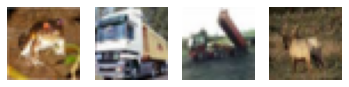

In [16]:
IMG_SIZE = 32
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1/256)
 ])
resize_images = train_ds.take(4).map(lambda x,y:resize_and_rescale(x))
show_images(resize_images)

# Other augumentation layers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


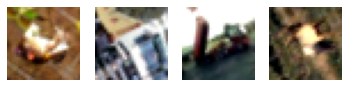

In [17]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=.2),
    tf.keras.layers.RandomContrast(factor=(.2,.9),),
])
aug_images = resize_images.map(lambda x: data_augumentation(x))
show_images(aug_images)

# Applying keras preprocessing layer to the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


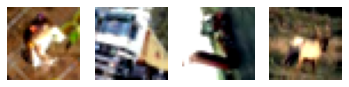

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    ds = ds.map(lambda x,y:
(resize_and_rescale(x),y),num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y:
(data_augumentation(x),y),num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)
prepared_ds = prepare(train_ds.take(4))
show_images(prepared_ds.map(lambda x,y:x))

# Adding augumentation keras layers to the model

In [19]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augumentation,
    tf.keras.layers.Conv2D(16,3),
    tf.keras.layers.MaxPooling2D(),
])
model.compile()

# Method 2

# Applyiny tranformations in a single image

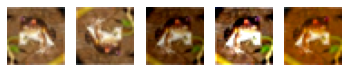

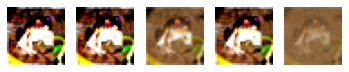

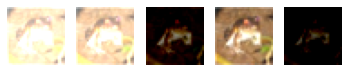

In [20]:
image,label = next(iter(train_ds))
show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image, -.2),
    tf.image.adjust_contrast(image,2),
    tf.image.adjust_saturation(image,2),
])

show_images([
    tf.image.stateless_random_contrast(image,lower=.1,upper=5,seed = (i,0))
    for i in range(1,6)
])
show_images([
    tf.image.stateless_random_brightness(image, max_delta=.8,seed = (i,0))
    for i in range(1,6)
])

# Applying augumentations to the dataset

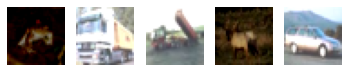

In [21]:
def resize_and_rescale(img):
    img = tf.cast(img,tf.float32)
    img = tf.image.resize(img,(32,32))
    img = img/255.0
    return img

def augument(img_label,seed):
    image,label = img_label
    image = resize_and_rescale(image)
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE,
3], seed=seed)
    image = tf.image.stateless_random_brightness(image, max_delta=0.5,
seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image,label
rng = tf.random.Generator.from_seed(1,alg="philox")
def augument_wrapper(image,label):
    seed = rng.make_seeds(2)[0]
    image,label = augument((image,label),seed)
    return image,label
augumented_ds = train_ds.take(5).map(augument_wrapper)
show_images(augumented_ds.map(lambda x,y:x))